In [1]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#import previously developed functions
#Allows us to get the mass of each seperate component for a galaxy
from ComponentMassFuncs import ComponentMass
#Reading the .txt files
from ReadFile import Read
#Allows us to get the COM position and velocity
from CenterOfMass import CenterOfMass

In [270]:
def RelativeMagnitude(a, b): #From HW6
    """
    Function to calculate an array of the relative magnitudes between a pair of 3D arrays.
    Example: center of mass position (x,y,z) of galaxy or velocity (vx, vy, vz)
    
    INPUTS:
        array1: 3D numpy array
        array2: 3D numpy array
        
    OUTPUTS:
        relmag: 1D numpy array
            Array of the relative vector magnitudes (array1 - array2)
    """
    A = a[:,0] - b[:,0] # compute relative "x" values
    B = a[:,1] - b[:,1] # compute relative "y" values
    C = a[:,2] - b[:,2] # compute relative "z" values
    
    relmag = np.sqrt(A**2 + B**2 + C**2) # compute magnitudes
    
    return relmag

## Goal: Isolate stellar streams and create ways to visualize them better, mainly in terms of velocity dispersion

![Diagram](./DiagramRA.png)

## Steps

1) Write a function that that outputs the Jacobi Radius (Based on Lab #4)

    $R_j = r  \bigg( \frac{M_{sat}}{2 M_{host}(<r)} \bigg)^{1/3}$

In [6]:
def JacobiRadius(M_sat, M_host, r):
    '''
    This function will calculate the Jacobi radius for a given galaxy at a given moment

    inputs:
        M_sat:
        M_host:
        r:

    outputs;
        R_j:
    '''
    R_j = r*(M_sat/(2*M_host))**(1/3)
    return R_j

2) Get the masses for the satellite and the host from previous assignments (HW3)

In [8]:
#For that we will use the ComponentMass function

In [9]:
#Setting up the masses
M_host = ComponentMass('M31_000.txt', 1) + ComponentMass('M31_000.txt', 2) + ComponentMass('M31_000.txt', 3)
M_sat = ComponentMass('M33_000.txt', 1) + ComponentMass('M33_000.txt', 2)

3) Retrieve separation from from the orbit files devised on (HW6)

In [11]:
#Getting the orbital info of M31 and M33
M31_Orbit = np.genfromtxt("Orbit_M31.txt")
M33_Orbit = np.genfromtxt("Orbit_M33.txt")
M31_M33_Sep = RelativeMagnitude(M33_Orbit[:, 1:4], M31_Orbit[:, 1:4])
M31_M33_Vel = RelativeMagnitude(M33_Orbit[:, 4:], M31_Orbit[:, 4:])

4) Retrieving code to determine relative position of particles in order to draw scatter plots weighted by velocity (Lab 7)

In [13]:
from RotateFrame import RotateFrame

## Attempts at visualizing the problem

In [15]:
#print(M31_M33_Sep[52])
#print(M31_Orbit[52,0])

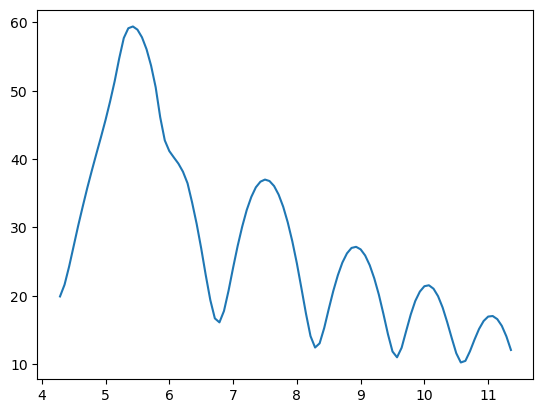

In [16]:
#Plot previewing how the Jacobi Radius for M33 changes over time
time = M31_Orbit[60:,0]
plt.plot(time,JacobiRadius(M_sat,M_host,M31_M33_Sep[60:]))
plt.show()

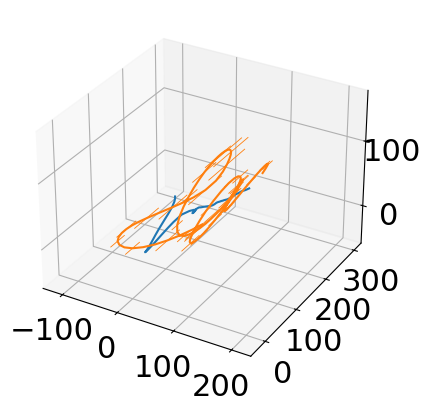

In [260]:
#Sample plot demonstrating the 3-D position of M33 with the Jacobi Radius as errorbars (A small part at least)
time = M31_Orbit[:,0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot(M31_Orbit[:,1], M31_Orbit[:,2], M31_Orbit[:,3])
ax.plot(M31_Orbit[52:160,1], M31_Orbit[52:160,2], M31_Orbit[52:160,3])
ax.errorbar(M33_Orbit[52:160,1], M33_Orbit[52:160,2], M33_Orbit[52:160,3], 
            yerr=JacobiRadius(M_sat,M_host,M31_M33_Sep[52:160]), elinewidth=0.6, errorevery=3)

plt.show()

## Functions Developed

In [274]:
def VelocityDisp(filenumber):
    '''
    This function uses code from Lab7 to plot the M33 disk particles color coded by velocity
    '''
    #Code from Lab 7 for contour and scatter plots
    COMD = CenterOfMass(f'../../../M33/M33_{filenumber}.txt',2)
    #This file is equivalent to the M33_Orbit[52] (because M33_Orbit has step=5)
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
    
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 
    
    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)
    
    # Determine velocities of disk particles relative to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 
    
    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
    
    # Arrays for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    
    #Rotate frame
    rn, vn = RotateFrame(r, v)
    
    #Arrays for Jacobi radius
    magnitudes = np.sqrt(np.sum(rn**2, axis=1))
    indx = filenumber/5.0
    threshold = np.array([JacobiRadius(M_sat, M_host, M31_M33_Sep[int(indx)])])
    print(threshold)
    
    # Create a mask for positions that meet the condition
    mask = magnitudes > threshold
    
    # Apply the mask to filter positions and corresponding velocities
    r_J = rn[mask]
    v_J = vn[mask]

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.scatter(rn[:,1], rn[:,2], c=vn[:,0])
    ax.add_patch(plt.Circle((0, 0), threshold, color='r', fill=False))

    #colorbar
    cbar = plt.colorbar()
    cbar.set_label('Vx (km/s)', size=22)
    
    # Add axis labels
    plt.xlabel('y (kpc)', fontsize=22)
    plt.ylabel('z (kpc)', fontsize=22)
    
    
    
    #adjust tick label font size
    label_size = 22
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size
    
    plt.show()

def VelocityDispMask(filenumber):
    '''
    This function uses code from Lab7 to plot the M33 disk particles color coded by velocity
        plus it masks particles within the jacobi radius for any given snapshot 
    '''
    #Code from Lab 7 for contour and scatter plots
    COMD = CenterOfMass(f'../../../M33/M33_{filenumber}.txt',2)
    #This file is equivalent to the M33_Orbit[52] (because M33_Orbit has step=5)
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
    
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 
    
    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)
    
    # Determine velocities of disk particles relative to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 
    
    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
    
    # Arrays for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T
    
    #Rotate frame
    rn, vn = RotateFrame(r, v)
    
    #Arrays for Jacobi radius
    magnitudes = np.sqrt(np.sum(rn**2, axis=1))
    indx = filenumber/5.0
    threshold = np.array([JacobiRadius(M_sat, M_host, M31_M33_Sep[int(indx)])])
    print(threshold)
    
    # Create a mask for positions that meet the condition
    mask = magnitudes > threshold
    
    # Apply the mask to filter positions and corresponding velocities
    r_J = rn[mask]
    v_J = vn[mask]

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.scatter(r_J[:,1], r_J[:,2], c=v_J[:,0])
    ax.add_patch(plt.Circle((0, 0), threshold, color='r', fill=False))

    #colorbar
    cbar = plt.colorbar()
    cbar.set_label('Vx (km/s)', size=22)
    
    # Add axis labels
    plt.xlabel('y (kpc)', fontsize=22)
    plt.ylabel('z (kpc)', fontsize=22)
    
    
    
    #adjust tick label font size
    label_size = 22
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size
    
    plt.show()

## Velocity Dispersion plots

[53.72908771]


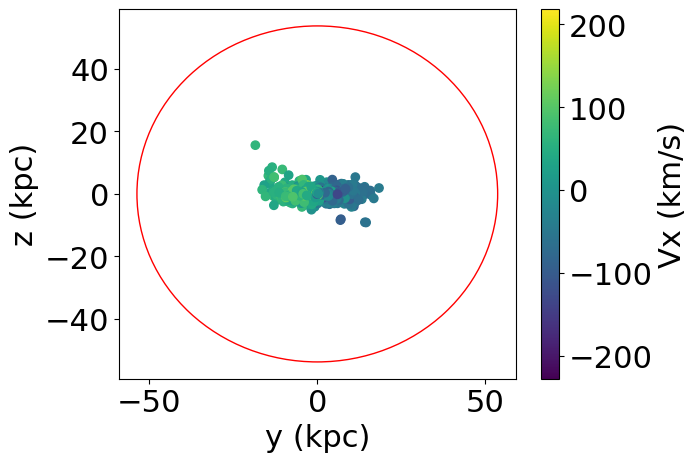

[31.13630466]


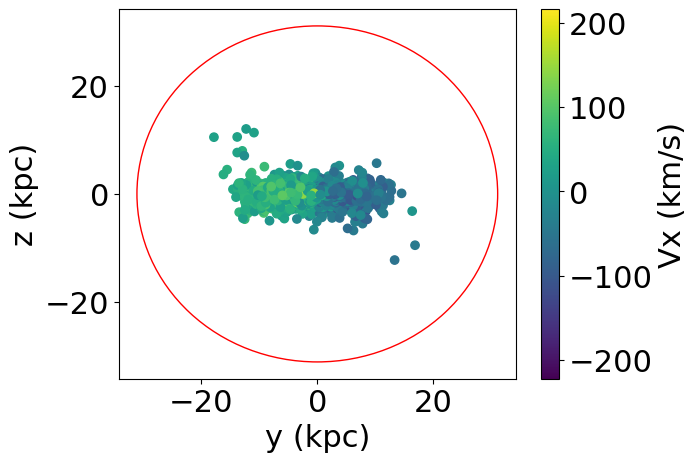

[19.89313437]


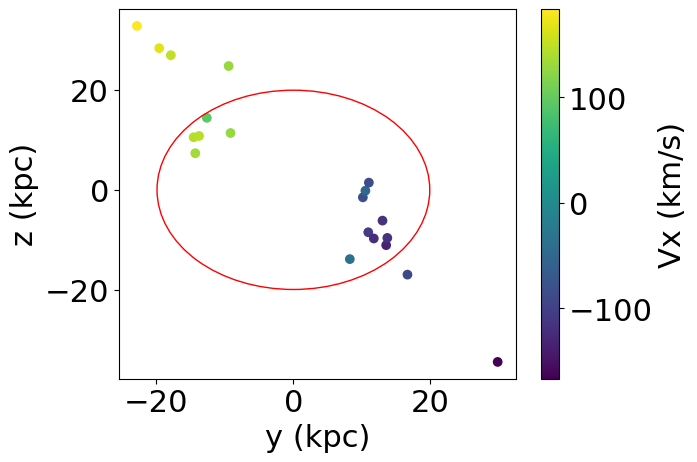

[30.25335839]


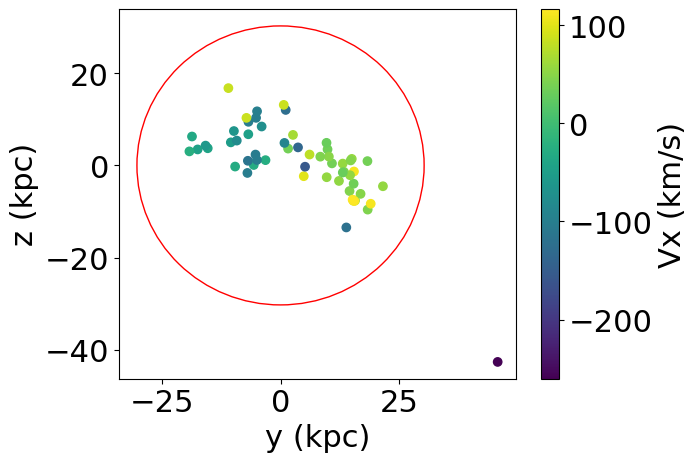

In [253]:
#Scatter plots coded by velocity of every disk particle
VelocityDisp(260)
VelocityDisp(280)
#Scatter plots coded by velocity of particles beyond the Jacobi Radius (Stellar Streams)
VelocityDispMask(300)
VelocityDispMask(320)

[41.17147526]


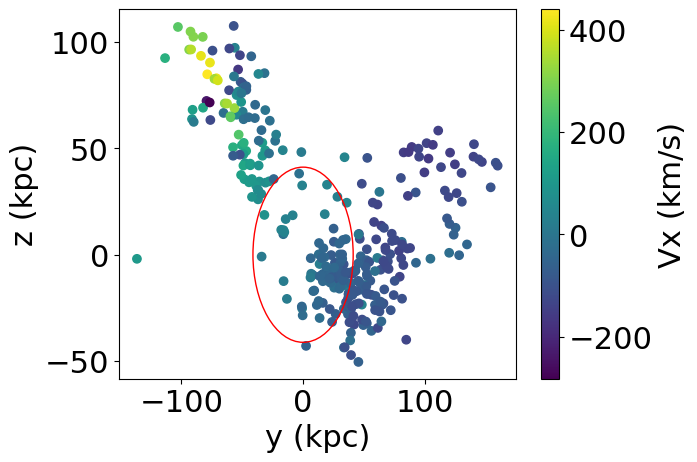

In [255]:
VelocityDispMask(420)

[23.02849753]


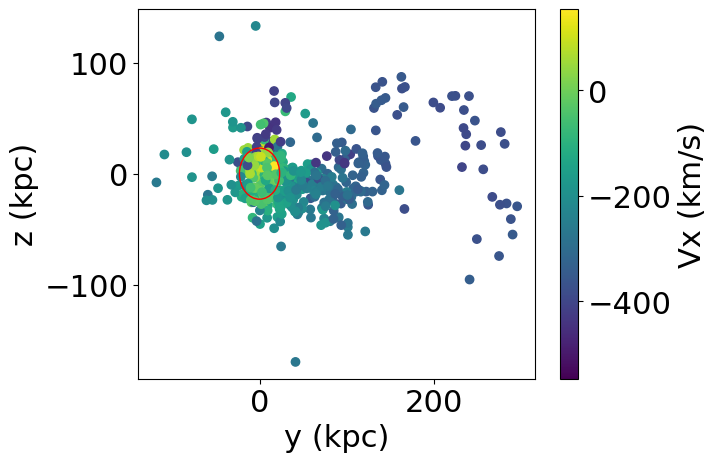

In [257]:
VelocityDispMask(460)